# Dependencies

In [1]:
!unzip "sports.zip"

Archive:  sports.zip
   creating: sports/
   creating: sports/test/
   creating: sports/test/air hockey/
  inflating: sports/test/air hockey/1.jpg  
  inflating: sports/test/air hockey/2.jpg  
  inflating: sports/test/air hockey/3.jpg  
  inflating: sports/test/air hockey/4.jpg  
  inflating: sports/test/air hockey/5.jpg  
   creating: sports/test/ampute football/
  inflating: sports/test/ampute football/1.jpg  
  inflating: sports/test/ampute football/2.jpg  
  inflating: sports/test/ampute football/3.jpg  
  inflating: sports/test/ampute football/4.jpg  
  inflating: sports/test/ampute football/5.jpg  
   creating: sports/test/archery/
  inflating: sports/test/archery/1.jpg  
  inflating: sports/test/archery/2.jpg  
  inflating: sports/test/archery/3.jpg  
  inflating: sports/test/archery/4.jpg  
  inflating: sports/test/archery/5.jpg  
   creating: sports/test/arm wrestling/
  inflating: sports/test/arm wrestling/1.jpg  
  inflating: sports/test/arm wrestling/2.jpg  
  inflating: sp

In [2]:
# Imports
import os

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

2025-06-02 08:25:51.331962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748852751.357118  112114 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748852751.365162  112114 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748852751.386980  112114 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748852751.387005  112114 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748852751.387006  112114 computation_placer.cc:177] computation placer alr

# Paths to Data

In [3]:
# Assuming the dataset was downloaded to the current directory
dataset_path = 'sports'

train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'valid')
test_path = os.path.join(dataset_path, 'test')

print(f"Training data path: {train_path}")
print(f"Validation data path: {val_path}")
print(f"Test data path: {test_path}")

Training data path: sports/train
Validation data path: sports/valid
Test data path: sports/test


# EDA: Exploratory Data Analysis

Count images per class:

In [4]:
for folder in os.listdir(train_path):
    print(f"{folder}: {len(os.listdir(os.path.join(train_path, folder)))} images")

bmx: 140 images
horseshoe pitching: 102 images
polo: 157 images
fly fishing: 134 images
uneven bars: 156 images
field hockey: 157 images
ultimate: 97 images
jai alai: 132 images
track bicycle: 135 images
speed skating: 136 images
shuffleboard: 130 images
harness racing: 147 images
figure skating pairs: 151 images
water polo: 130 images
boxing: 116 images
mushing: 111 images
olympic wrestling: 167 images
cheerleading: 131 images
tennis: 131 images
snowmobile racing: 147 images
rock climbing: 141 images
wingsuit flying: 98 images
horse jumping: 134 images
sumo wrestling: 133 images
disc golf: 123 images
baseball: 174 images
tug of war: 128 images
frisbee: 131 images
basketball: 169 images
football: 191 images
sky surfing: 59 images
steer wrestling: 122 images
wheelchair basketball: 106 images
skydiving: 148 images
sidecar racing: 133 images
bull riding: 149 images
billiards: 145 images
baton twirling: 108 images
chuckwagon racing: 120 images
ski jumping: 130 images
swimming: 157 images
g

Visualize a few sample images:

Text(0.5, 1.0, 'Sample Image')

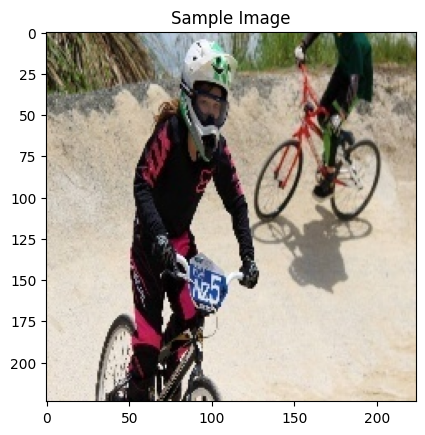

In [5]:
img = cv2.imread("sports/train/bmx/001.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Image")

Plot class distribution (bar chart):

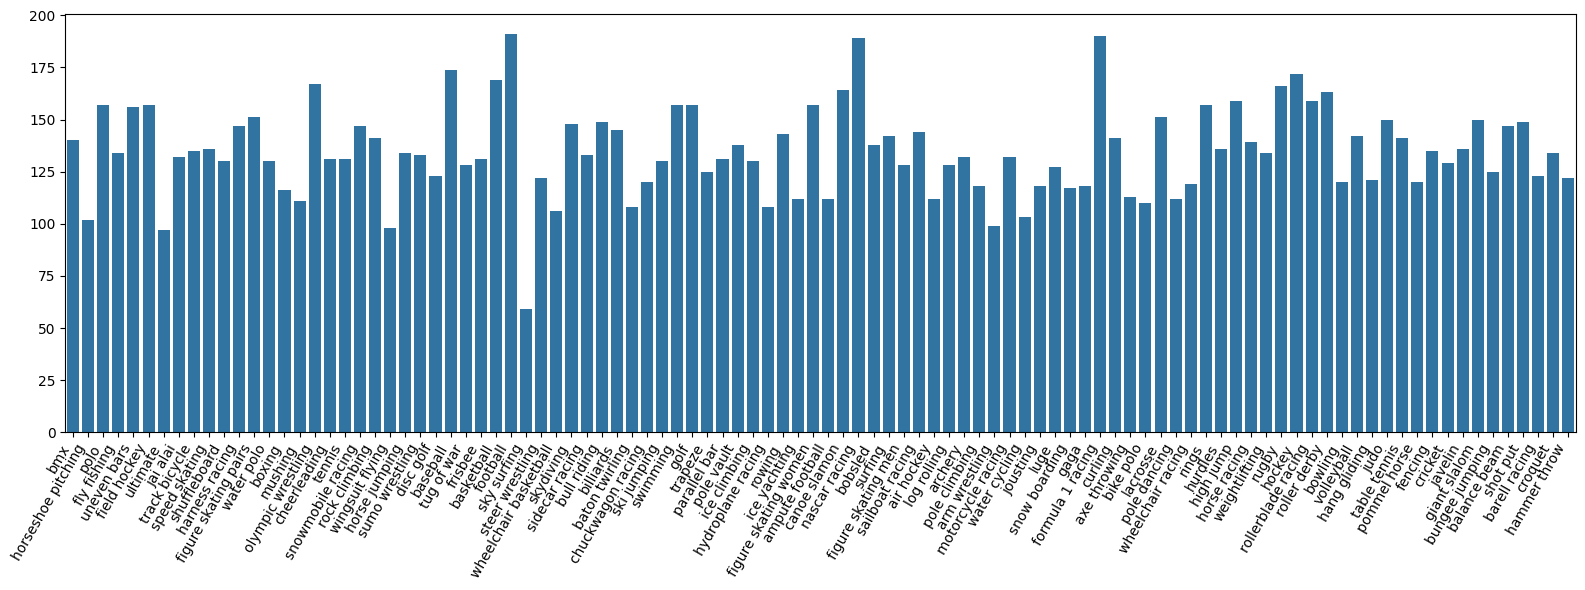

In [6]:
class_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in os.listdir(train_path)}
plt.figure(figsize=(16, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

Check For Corrupted Images:

In [7]:
def check_corrupted_images(path):
    corrupted_images = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                corrupted_images.append(img_path)
    return corrupted_images

In [8]:
corrupted_train_images = check_corrupted_images(train_path)
if corrupted_train_images:
    print("Corrupted training images:", corrupted_train_images)
else:
    print("No corrupted training images found.")
corrupted_train_images = check_corrupted_images(train_path)

for img_path in corrupted_train_images:
    os.remove(img_path)
    print(f"Removed: {img_path}")

Corrupted training images: ['sports/train/high jump/159.lnk']
Removed: sports/train/high jump/159.lnk


Plot Image Properties:

In [9]:
image_sizes = []
aspect_ratios = []

for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            height, width, _ = img.shape
            image_sizes.append((width, height))
            aspect_ratios.append(width / height)

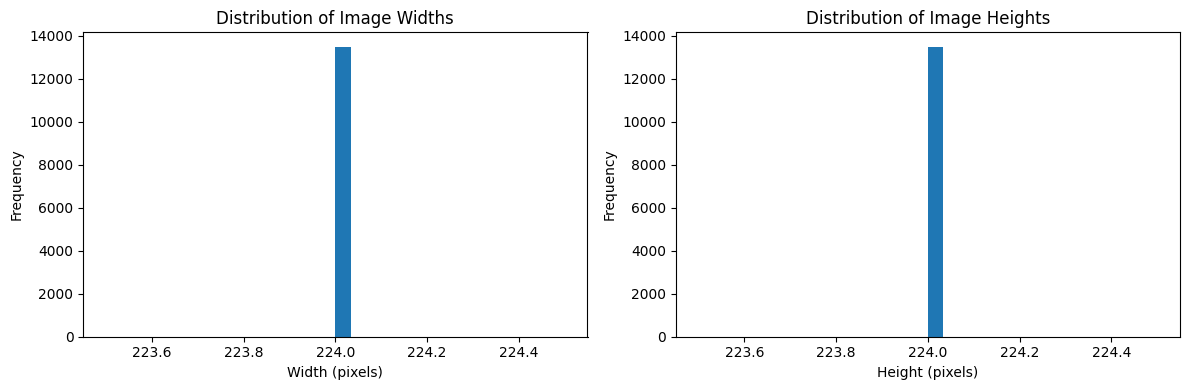

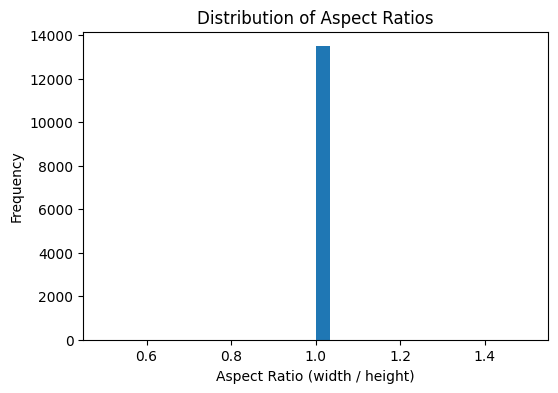

/tmp/ipykernel_112114/2325455579.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([widths, heights], labels=['Widths', 'Heights'])


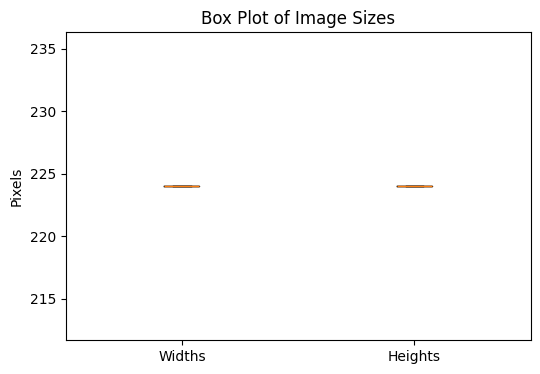

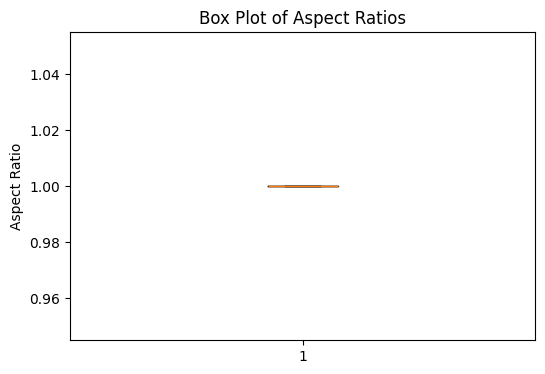

In [10]:
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(aspect_ratios, bins=30)
plt.title('Distribution of Aspect Ratios')
plt.xlabel('Aspect Ratio (width / height)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 4))
plt.boxplot([widths, heights], labels=['Widths', 'Heights'])
plt.title('Box Plot of Image Sizes')
plt.ylabel('Pixels')
plt.show()

plt.figure(figsize=(6, 4))
plt.boxplot(aspect_ratios)
plt.title('Box Plot of Aspect Ratios')
plt.ylabel('Aspect Ratio')
plt.show()

Plot RGB Graphs For Image (Sample):

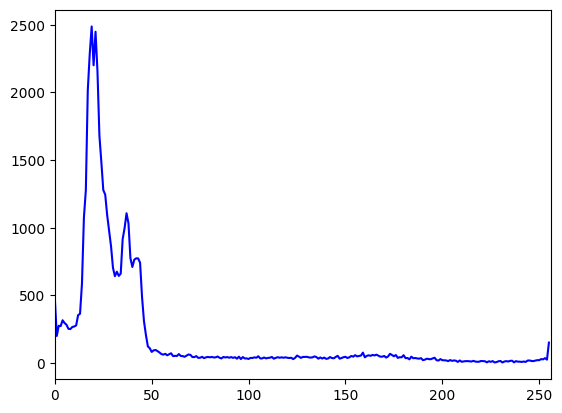

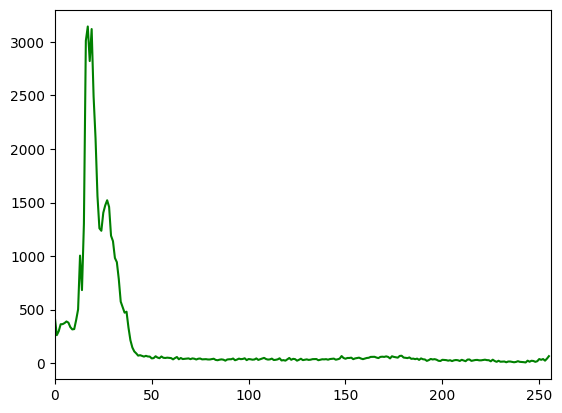

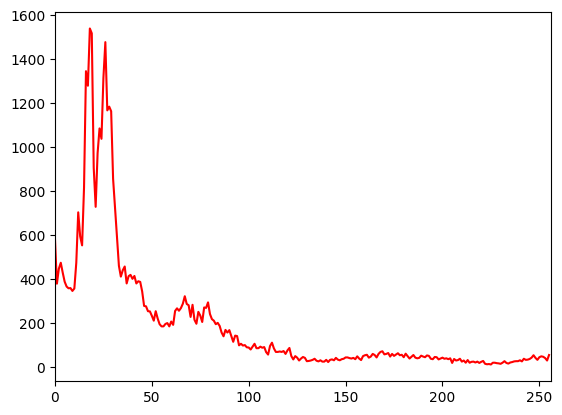

In [11]:
image_path = 'sports/train/archery/001.jpg'

img = cv2.imread(image_path)
color = ('b','g','r')
for i,col in enumerate(color):
  histr = cv2.calcHist([img],[i],None,[256],[0,256])
  plt.plot(histr,color = col)
  plt.xlim([0,256])
  plt.show()

Convert Image To Grayscale (Sample):

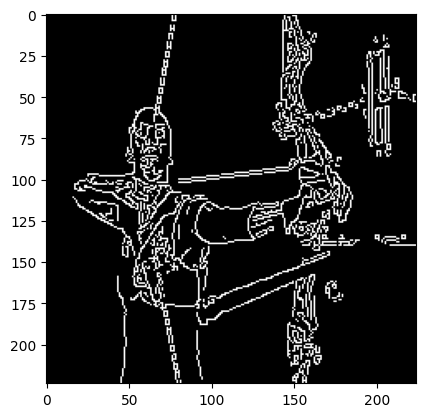

In [12]:
image_path = 'sports/train/archery/001.jpg'

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(img, 100, 200)
plt.imshow(edges, cmap='gray')
plt.show()

# Define Image Data Generators (Augmentation + Rescale)

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow Data from Directories

In [14]:
train_gen = train_datagen.flow_from_directory(train_path,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

val_gen = val_datagen.flow_from_directory(val_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='categorical')

test_gen = test_datagen.flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle=False)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 101 classes.


# Plot Some Train Data

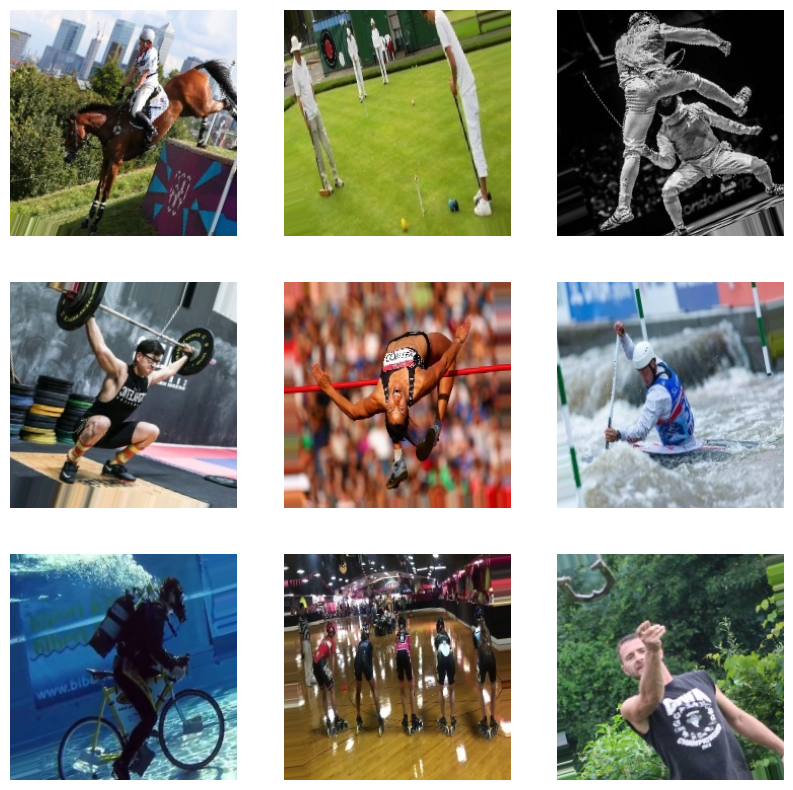

In [15]:
x_batch, y_batch = next(train_gen)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')

# Create Convolutional Neural Network

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

/home/ilesh-dhall/Sports-Classification-Neural-Nexus/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748852821.980681  112114 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [17]:
# Summarize the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,181,860 (42.66 MB)

 Trainable params: 11,181,860 (42.66 MB)

 Non-trainable params: 0 (0.00 B)

# Callbacks Setup

In [18]:
checkpoint = ModelCheckpoint("models/best_model.keras", save_best_only=True)
earlystop = EarlyStopping(patience=5, restore_best_weights=True)

# Compile the Model

In [19]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model

In [27]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 117s 277ms/step - accuracy: 0.0476 - loss: 4.3439 - val_accuracy: 0.1140 - val_loss: 3.9787
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 105s 249ms/step - accuracy: 0.0750 - loss: 4.0939 - val_accuracy: 0.1840 - val_loss: 3.5390
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 113s 267ms/step - accuracy: 0.1155 - loss: 3.8203 - val_accuracy: 0.2300 - val_loss: 3.3465
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 110s 259ms/step - accuracy: 0.1499 - loss: 3.5973 - val_accuracy: 0.2600 - val_loss: 3.1552
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 111s 264ms/step - accuracy: 0.1905 - loss: 3.3806 - val_accuracy: 0.2900 - val_loss: 2.8791
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 115s 272ms/step - accuracy: 0.2044 - loss: 3.2563 - val_accuracy: 0.3000 - val_loss: 2.8090
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 141s 333ms/step - accuracy: 0.2246 - loss: 3.1514 - val_accuracy: 0.3360 - val_loss: 2.7238
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 126s 297ms/step - accuracy: 0.2470 -

# Show Training History (Accuracy & Loss)

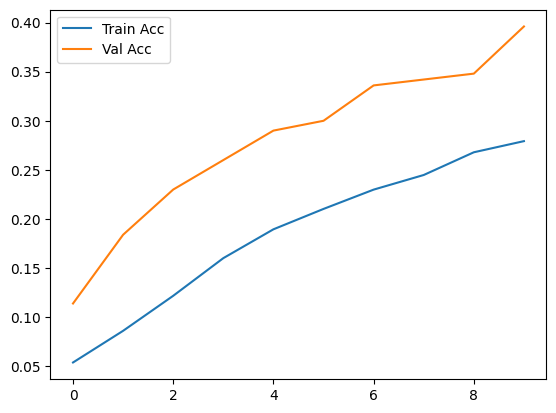

In [28]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

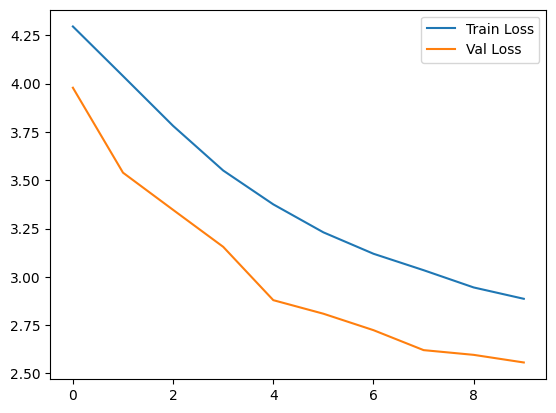

In [29]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# Save the Model

In [30]:
model.save("models/final_model.h5")

# Load Best Weights

In [31]:
model.load_weights("models/final_model.h5")

# Make Predictions

In [33]:
predictions = model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


# Confusion Matrix & Report

/home/ilesh-dhall/Sports-Classification-Neural-Nexus/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ilesh-dhall/Sports-Classification-Neural-Nexus/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ilesh-dhall/Sports-Classification-Neural-Nexus/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this

                       precision    recall  f1-score   support

           air hockey       0.44      0.80      0.57         5
      ampute football       0.50      0.20      0.29         5
              archery       1.00      0.20      0.33         5
        arm wrestling       0.50      0.40      0.44         5
         axe throwing       0.33      0.20      0.25         5
         balance beam       0.25      0.40      0.31         5
        barell racing       0.43      0.60      0.50         5
             baseball       0.00      0.00      0.00         5
           basketball       0.20      0.20      0.20         5
       baton twirling       0.00      0.00      0.00         5
            bike polo       0.33      0.20      0.25         5
            billiards       0.60      0.60      0.60         5
                  bmx       0.50      0.40      0.44         5
              bobsled       0.00      0.00      0.00         5
              bowling       1.00      0.20      0.33  

<Axes: >

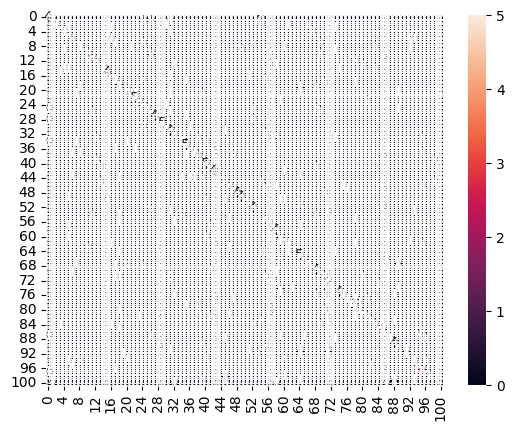

In [34]:
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True)


#  Save Predictions (Optional)

In [35]:
df = pd.DataFrame({'Filename': test_gen.filenames, 'Actual': y_true, 'Predicted': y_pred})
df.to_csv('results/predictions.csv', index=False)

# Show Sample Predictions

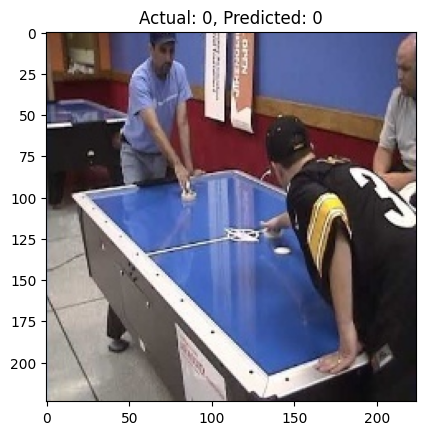

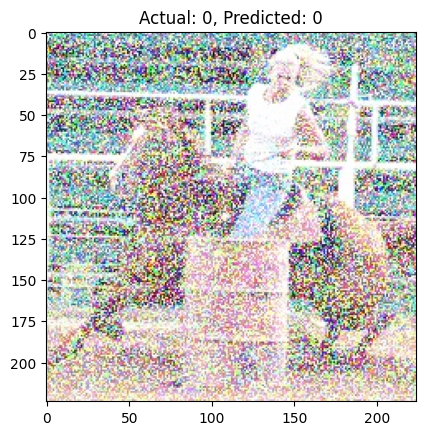

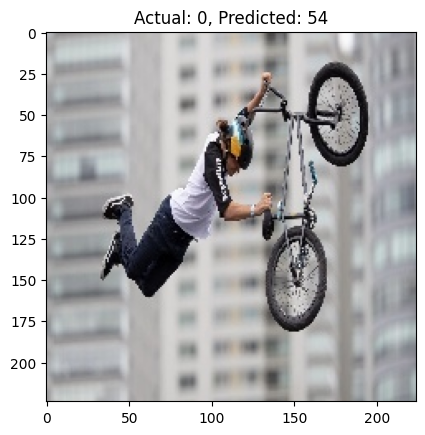

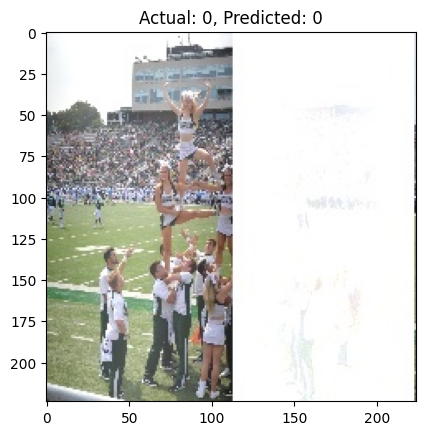

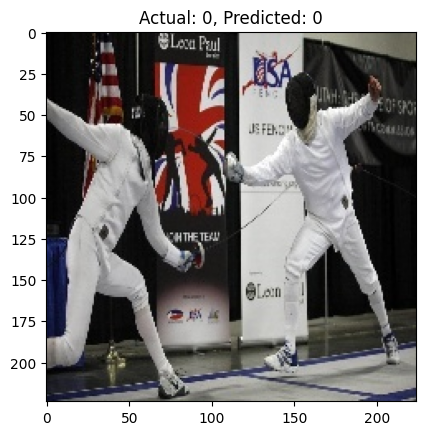

In [36]:
for i in range(5):
    img = test_gen[i][0][0]
    plt.imshow(img)
    plt.title(f"Actual: {y_true[i]}, Predicted: {y_pred[i]}")
    plt.show()